1. 
    a) Данные можно использовать для предсказания какого-нибудь признака на основе всех остальных признаков (например: предсказание цены автомобиля). Если признак категориальный, то это задача классификации, а если количественный, то задача регрессии.

    b) Так же например можно создать систему, в которой пользователь указывает свои пожелания насчет машины. Можно было бы выдать ему просто все машины, которые подходят по отмеченным параметрам, но подходящих машин может быть очень мало, а пользователь не прочь бы и посмотреть на похожие машины, которые могут просто немного отличаются по параметрам. Для этого мы по отмеченным признакам кластеризуем все машины на несколько классов, предсказываем класс машины, которую пользователь примерно желает и выдаем ему список машин из подходящего класса. 
    
    с) Далее у нас к примеру собираются данные, по которым понятно какую все-таки машину или несколько выбрал пользователь. Мы можем потом для вновь пришедшего пользователя находить на него похожих по выбранным признакам и уже на основе похожих строить рекомендательную систему.
    
2. Задача предсказания цены автомобиля. Решение задачи сделано с помощью xgboost. В gradient boosting machine или просто GBM финальная предсказательная модель строится на основе ансамбля слабых предсказательных моделей. Принципиальная идея этого алгоритма состоит в том, чтобы строить новые слабые модели для максимальной корреляции с отрицательным градиентом функции потерь, связанным со всем остальным ансамблем. Выбран именно этот алгоритм, так как оно хорошо показывает себя в практических задачах, а так же в соревновательных задачах.

3. Для обучения в GBM необходимо было сначала обработать и подготовить данные. Были убраны объекты, у которых на месте признаков 'normalized-losses' и 'num-of-doors'. После этого осталось очень мало пропусков и они были заполнены просто 0. Для заполнения пропусков можно было бы использовать среднюю величину всего столбца или более сложные алгоритмы, здесь они были просто убраны. Далее категориальные признаки преобразованы в dummy переменные, так как данный подход показывает улучшение точности финальной модели. Далее для оценки модели была проведеная 3-fold кросс-валидация с заданными параметрами модели. Была активирована ранняя остановка. Ошибка CV должна уменьшаться каждый раунд для продолжения. После этого стало известно оптимальное число слабых моделей в gbm. Далее финальная модель была обучена на всем множестве данных с оптимальным числом слабых моделей. Для оценки модели была использована метрика 'rmse'.
    
    Так же для сравнения была еще взята модель линейной регрессии и проведен анализ двух моделей на 3-fold кросс-валидации с метрикой 'r2', у линейной регресии r2_score вышел равным 0.326526953803, а у xgboost модели -- 0.695171458279.

4. Если было бы больше времени, то можно было бы провести future selection, а так же изобрести новые признаки. Сделать stacking моделей xgboost. Так же можно было бы максимально эффективно заполнить пропуски в данных.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
%pylab inline

/home/georgy/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/home/georgy/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv('../data/dataset.csv')

In [3]:
data.head(n=10)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
7,1,?,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,?


In [4]:
data.shape

(205, 26)

In [5]:
data.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [6]:
def check_columns_with_empty_ceils(data):
    data_replace = data.replace('?', np.nan)
    for column in data_replace.columns:
        print column + ': ' + str(len(data_replace[data_replace[column].isnull()]))
    

In [7]:
def data_preparing(data):
    data = data.replace('?', 0)
    data = data.fillna(0)
    target = data['price'].astype(int)
    data = data.drop(['price'], axis = 1)
    data = pd.get_dummies(data, columns=['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'])
    return data, target


In [8]:
check_columns_with_empty_ceils(data)

symboling: 0
normalized-losses: 41
make: 0
fuel-type: 0
aspiration: 0
num-of-doors: 2
body-style: 0
drive-wheels: 0
engine-location: 0
wheel-base: 0
length: 0
width: 0
height: 0
curb-weight: 0
engine-type: 0
num-of-cylinders: 0
engine-size: 0
fuel-system: 0
bore: 4
stroke: 4
compression-ratio: 0
horsepower: 2
peak-rpm: 2
city-mpg: 0
highway-mpg: 0
price: 4


In [9]:
#removing samples with empty 'normalized-losses' feature
data = data[data['normalized-losses'] != '?']

In [10]:
data.shape

(164, 26)

In [11]:
check_columns_with_empty_ceils(data)

symboling: 0
normalized-losses: 0
make: 0
fuel-type: 0
aspiration: 0
num-of-doors: 1
body-style: 0
drive-wheels: 0
engine-location: 0
wheel-base: 0
length: 0
width: 0
height: 0
curb-weight: 0
engine-type: 0
num-of-cylinders: 0
engine-size: 0
fuel-system: 0
bore: 4
stroke: 4
compression-ratio: 0
horsepower: 0
peak-rpm: 0
city-mpg: 0
highway-mpg: 0
price: 0


In [12]:
#removing samples with empty 'num-of-doors' feature
data = data[data['num-of-doors'] != '?']

In [13]:
data.shape

(163, 26)

In [14]:
X, y = data_preparing(data)

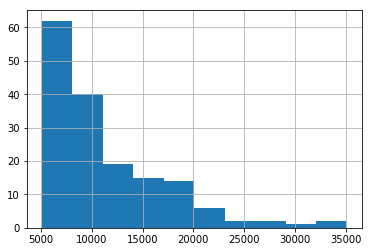

In [15]:
y.hist()

In [ ]:
model = xgb.XGBRegressor()
model_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [300, 1000, 2000],
    'max_depth': [2, 3, 5, 10],
}
cv = StratifiedKFold(n_splits=3)
grid = GridSearchCV(model, model_params, verbose=10,n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

In [16]:
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=2000,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.8,
    objective="reg:linear",
    reg_alpha=0.01,
    seed=0,
)

In [17]:
xgtrain = xgb.DMatrix(data=X.as_matrix(), label=y.as_matrix())

In [18]:
xgb_param = model.get_xgb_params()
cvresult = xgb.cv(
    xgb_param,
    xgtrain,
    num_boost_round=xgb_param['n_estimators'],
    nfold=3, 
    verbose_eval=20,
    early_stopping_rounds=50,
    metrics='rmse'
)

[0]	train-rmse:11645.9+609.451	test-rmse:11606.9+1177.51
[20]	train-rmse:2393.16+100.742	test-rmse:3000.4+739.912
[40]	train-rmse:1173.27+66.2469	test-rmse:2145.21+608.114
[60]	train-rmse:890.967+53.9863	test-rmse:2103.22+591.468
[80]	train-rmse:714.651+38.7363	test-rmse:2088.74+564.067
[100]	train-rmse:597.262+33.3085	test-rmse:2114.12+561.804
[120]	train-rmse:512.076+36.544	test-rmse:2133.02+557.484


In [19]:
cvresult.shape[0]

82

In [20]:
model.set_params(n_estimators=cvresult.shape[0])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=82, nthread=-1,
       objective='reg:linear', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [21]:
model.fit(X.as_matrix(), y.as_matrix(), eval_metric='rmse')

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=82, nthread=-1,
       objective='reg:linear', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.33, random_state=53)

In [32]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [33]:
from sklearn.model_selection import cross_val_score

In [36]:
print(cross_val_score(lr, X, y, scoring='r2', cv=3).mean())

0.326526953803


In [37]:
print(cross_val_score(model, X.as_matrix(), y.as_matrix(), scoring='r2', cv=3).mean())

0.695171458279


Некоторые интересные графики 

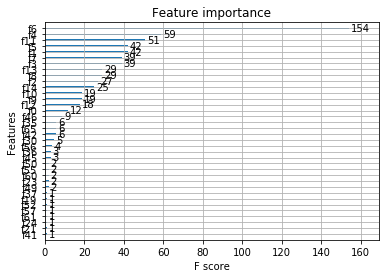

In [38]:
xgb.plot_importance(model)

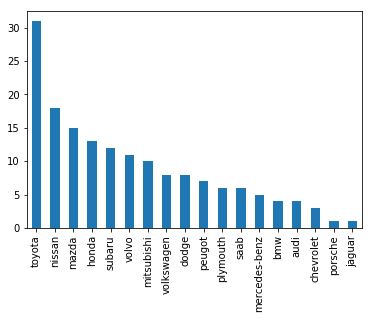

In [39]:
data['make'].value_counts().plot(kind='bar')

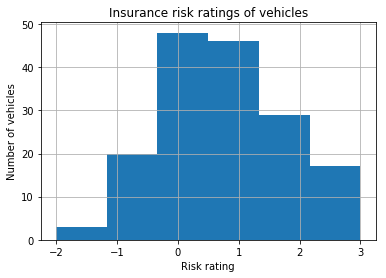

In [40]:
#Insurance risk rating Histogram
data.symboling.hist(bins=6)
plt.title("Insurance risk ratings of vehicles")
plt.ylabel('Number of vehicles')
plt.xlabel('Risk rating');

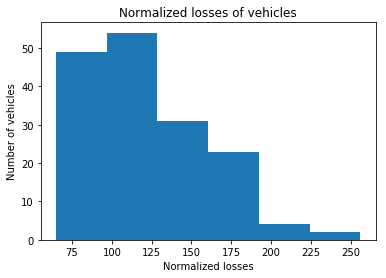

In [41]:
#Normalized losses histogram
data['normalized-losses'].astype(int).hist(bins=6,grid=False)
plt.title("Normalized losses of vehicles")
plt.ylabel('Number of vehicles')
plt.xlabel('Normalized losses');

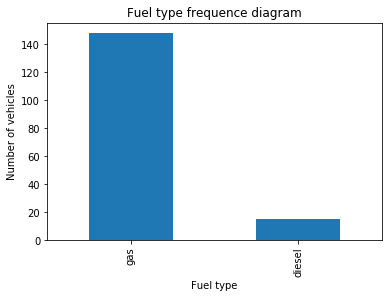

In [42]:
#Fuel type chart
data['fuel-type'].value_counts().plot(kind='bar', )
plt.title("Fuel type frequence diagram")
plt.ylabel('Number of vehicles')
plt.xlabel('Fuel type');